In [76]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pylab as plt
from sklearn import datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pandas as pd
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
import shap

In [77]:
# transforming csv into a DataFrame object
# import data and split
df_lag = pd.read_csv("rawdata.csv")
train_set = df_lag.iloc[:,0:48]
labels = df_lag.iloc[:,48:49]
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_set, labels, random_state=0)



## Decision Tree

In [78]:
# model and fit
cls_t = tree.DecisionTreeClassifier()
cls_t.fit(X_train, y_train)
y_pred = cls_t.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.903598971722365

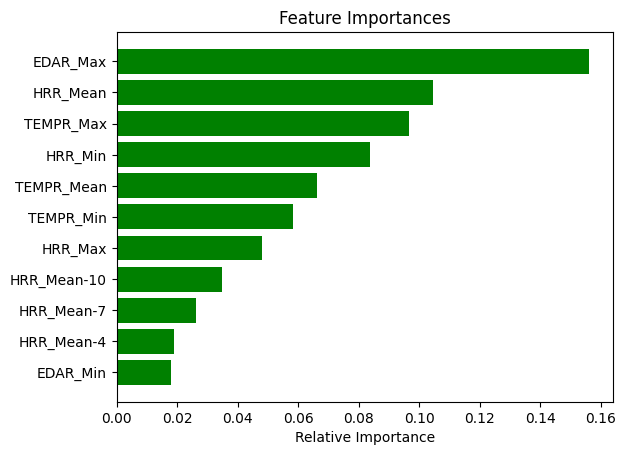

In [79]:
# -- feature importance graph
importances = cls_t.feature_importances_
indices = np.argsort(importances)
features = df_lag.columns
plt.title('Feature Importances')
j = 11   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

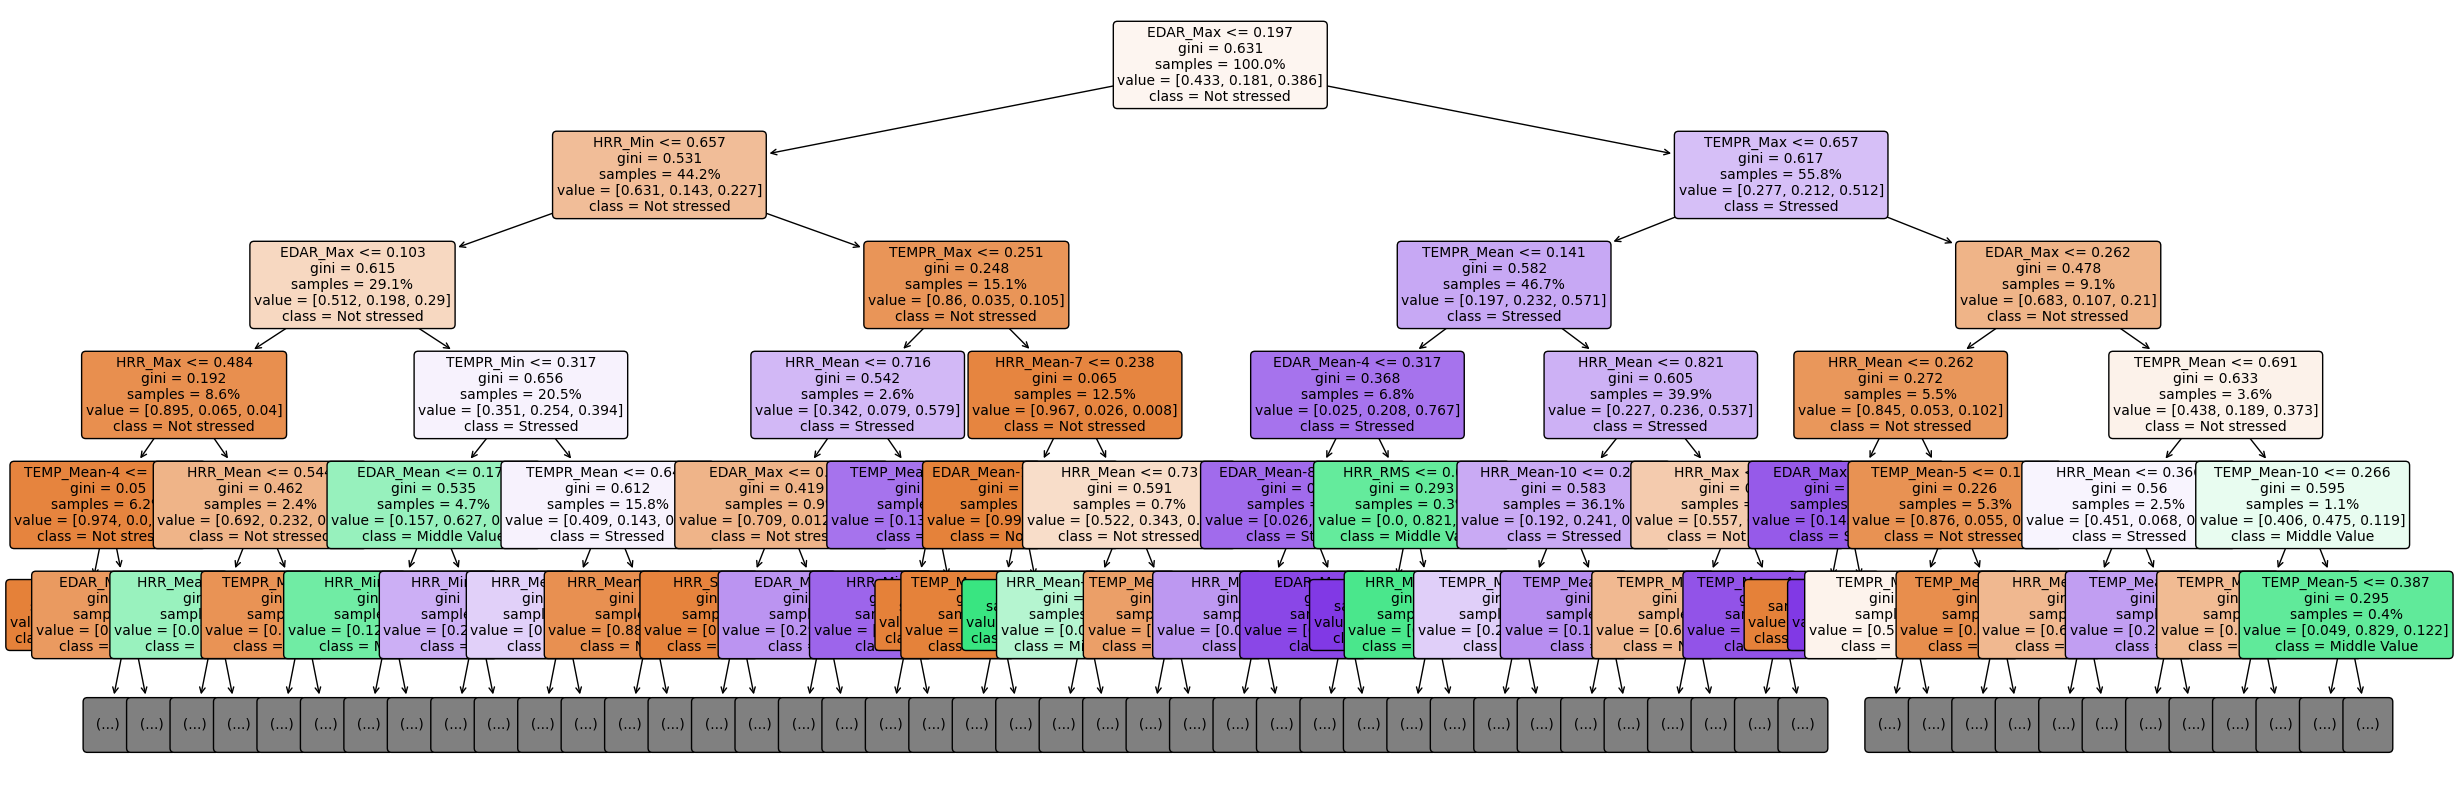

In [80]:
# visualização da arvore de decisões
fig = plt.figure(figsize=(30, 10))
vis = tree.plot_tree(cls_t, feature_names = df_lag.columns.to_list(), class_names = ['Not stressed', 'Middle Value', 'Stressed'], max_depth=5, fontsize=10, proportion=True, filled=True, rounded=True)
#plt.savefig('tree4.eps',format='eps')

## Random Forest

In [81]:
# acurácia do rf
clf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

C:\Users\luiza\AppData\Local\Temp\ipykernel_15620\1834918725.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9652956298200515

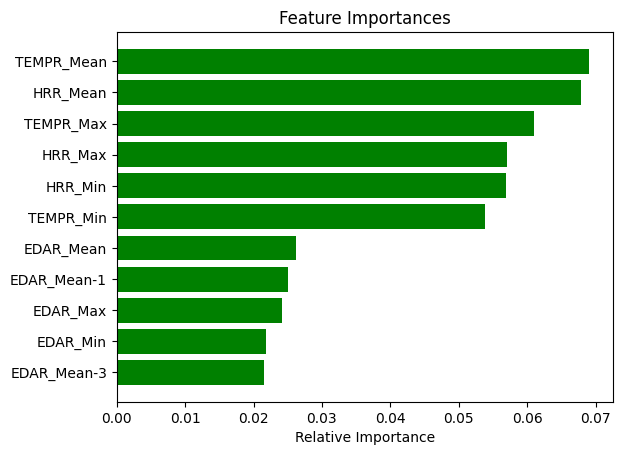

In [82]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = df_lag.columns
plt.title('Feature Importances')
j = 11   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

In [83]:
#criação da arvore de decisoes
estimator = clf.estimators_[5]

dot_data = export_graphviz(estimator, 
                    feature_names=df_lag.columns[:48].tolist(),
                    class_names=['Not stressed', 'Middle Value', 'Stressed'],
                    rounded=True, proportion=False, 
                    precision=2, filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.581893 to fit



## Explicável

In [84]:
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

Variable Importance Plot - Global Interpretation


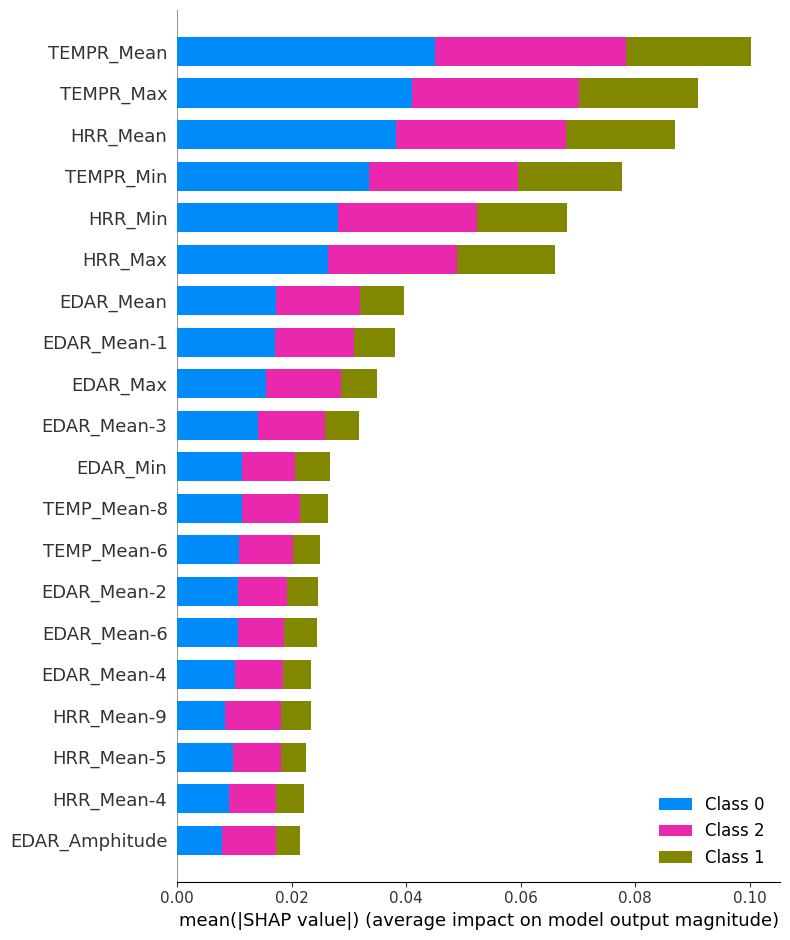

In [85]:
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test)

Summary Plot para a classe: Not stressed


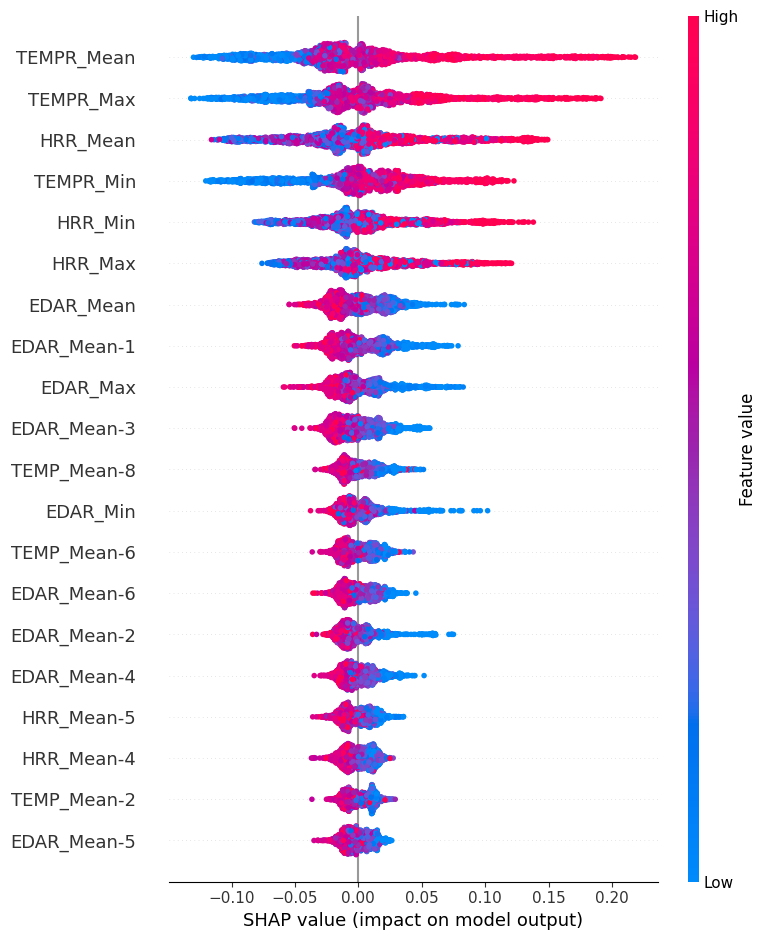

Summary Plot para a classe: Middle Value


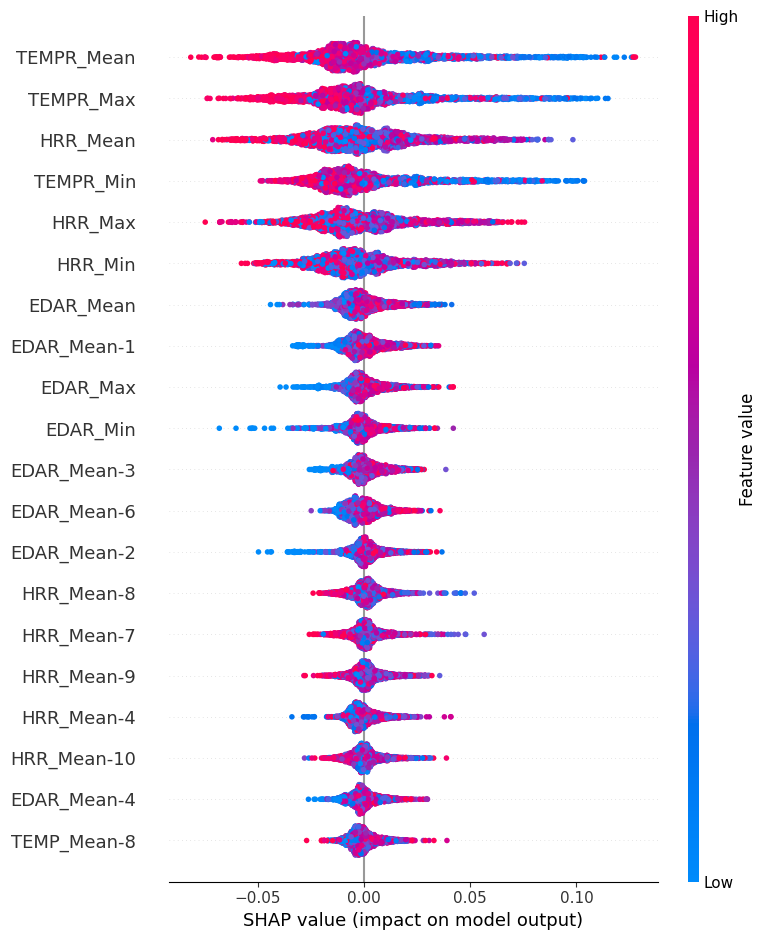

Summary Plot para a classe: Stressed


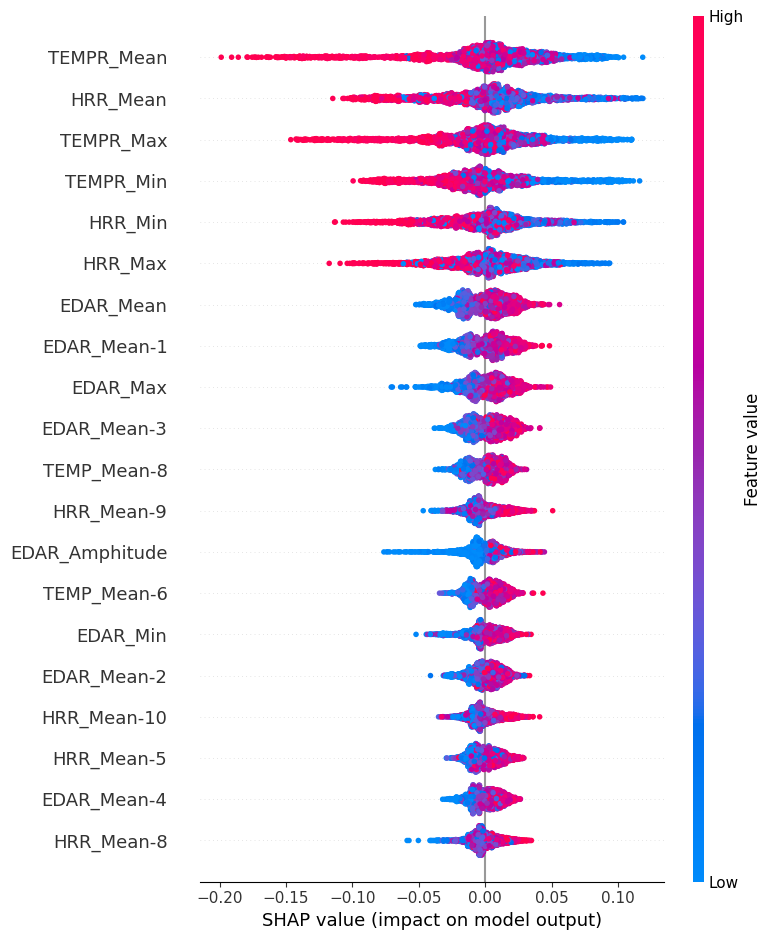

In [86]:
class_names = ['Not stressed', 'Middle Value', 'Stressed']
for class_index, class_name in enumerate(class_names):
    print("Summary Plot para a classe:", class_name)
    plt.figure()
    shap.summary_plot(shap_values[class_index], X_test, class_names=[class_name])
    plt.show()

In [87]:
from lime.lime_tabular import LimeTabularExplainer
feature_names = list(X_train.columns)

explainer = LimeTabularExplainer(X_train.values, feature_names = feature_names,class_names = class_names, mode = 'classification')
exp = explainer.explain_instance(X_test.iloc[0], clf.predict_proba, num_features=10, top_labels=3)
exp.show_in_notebook()

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names


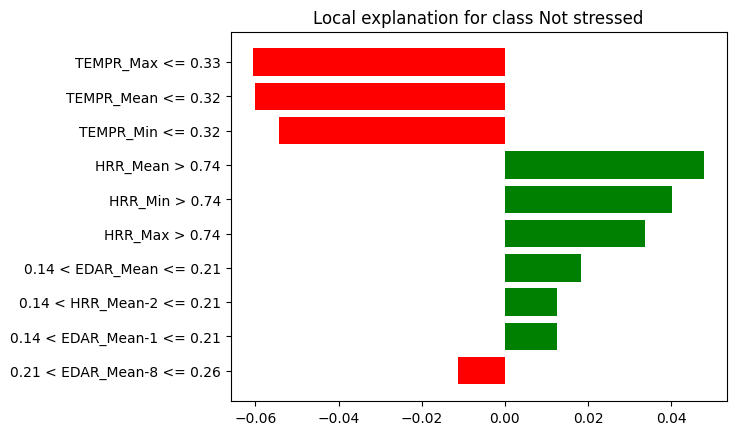

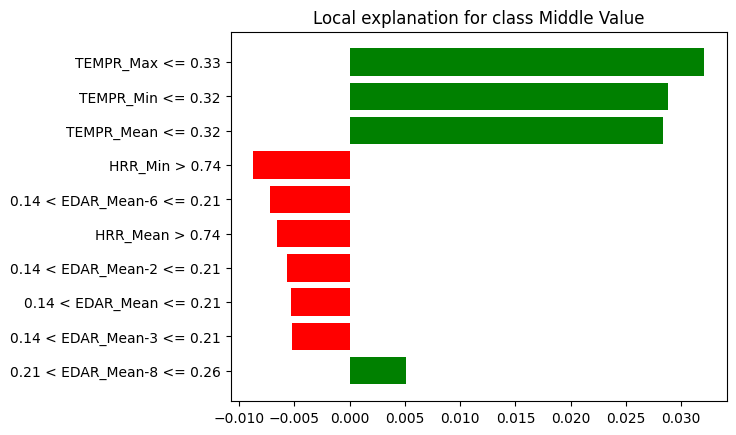

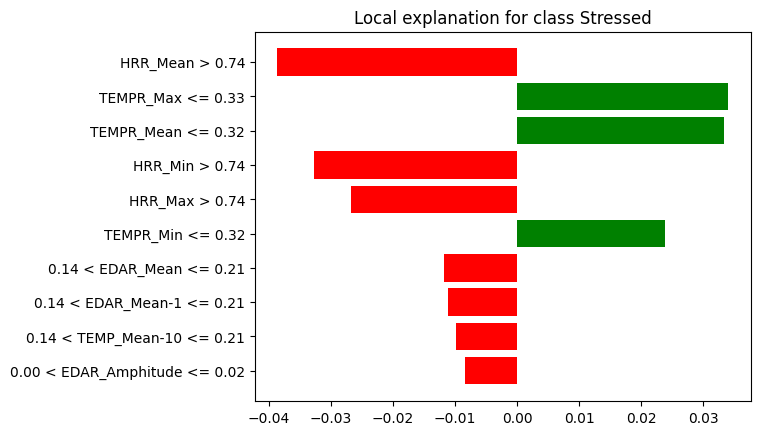

In [88]:
for i, class_names in enumerate(class_names):
    # Gerar explicação para a categoria atual
    exp = explainer.explain_instance(X_train.iloc[1, :], clf.predict_proba, num_features=10, labels=[i])
    
    # Gerar figura para a explicação atual
    fig = exp.as_pyplot_figure(label=i)

In [89]:
import xgboost as xgb
import explainerdashboard as expdb
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from explainerdashboard import InlineExplainer
from explainerdashboard.custom import (ImportancesComposite,
                                       IndividualPredictionsComposite,
                                       WhatIfComposite,
                                       ShapDependenceComposite,
                                       ShapInteractionsComposite,
                                       DecisionTreesComposite)
xgb_mod = xgb.XGBClassifier()
xgb_mod.fit(X_train, y_train)

explainer = ClassifierExplainer(xgb_mod, X_test, y_test,model_output='logodds')

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [93]:
ExplainerDashboard(explainer, mode='inline').run(port=8060)

Building ExplainerDashboard..
Generating layout...


c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\dash\dash.py:550: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.


Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8060))


In [92]:
import shapash
from shapash.explainer.smart_explainer import SmartExplainer

xpl = SmartExplainer(xgb_mod)
xpl.compile(
    x=X_test
)
app = xpl.run_app(title_story='Stress')
xpl.plot.features_importance()
xpl.plot.top_interactions_plot(nb_top_interactions=5)

predictor = xpl.to_smartpredictor()
predictor.add_input(x=X_train, ypred=y_train)
detailed_contributions = predictor.detail_contributions()

#para visualizar, clicar no link indicado com `INFO:root:Your Shapash application run on -----`

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x0000027E6B5CFE20>


INFO:root:Your Shapash application run on http://Luiza:8050/
INFO:root:Use the method .kill() to down your app.
Exception in thread Thread-1032 (<lambda>):
Traceback (most recent call last):
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py", line 198, in _new_conn
    sock = connection.create_connection(
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
OSError: [WinError 10049] O endereço solicitado não é válido no contexto

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py", line 793, in urlopen
    response = s

INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x0000027E6B5CFE20>
INFO: Shap explainer type - <shap.explainers._tree.TreeExplainer object at 0x0000027E6B5CFE20>
